In [1]:
import pandas as pd
import pandera as pa
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
poke_df = pd.read_csv("pokemon.csv")
poke_df.columns

Index(['pokedex_number', 'name', 'generation', 'classfication', 'abilities',
       'height_m', 'weight_kg', 'type1', 'type2', 'base_total', 'hp', 'attack',
       'defense', 'sp_attack', 'sp_defense', 'speed', 'against_bug',
       'against_dark', 'against_dragon', 'against_electric', 'against_fairy',
       'against_fighting', 'against_fire', 'against_flying', 'against_ghost',
       'against_grass', 'against_ground', 'against_ice', 'against_normal',
       'against_poison', 'against_psychic', 'against_rock', 'against_steel',
       'against_water', 'capture_rate', 'base_egg_steps', 'base_happiness',
       'is_legendary', 'is_mythical', 'is_mega'],
      dtype='object')

## Data Analysis for Pokemon
* How many fire pokemons are there?
* What's the mean sp. Atk of all pokemons?
* Get the speed tier of pokemons
    * Get all abilities that affect speed
    * Apply the speed with abilities

In [3]:
pokemon_type = pd.read_csv("pokemon.csv",  index_col=["pokedex_number"], usecols=["pokedex_number", "name", "type1", "type2"])

In [4]:
pokemon_type.shape

(1033, 3)

## How many *fire* pokemons are there?

In [5]:
type = "Psychic"

### Sanity Check

In [6]:
pokemon_schema = pa.DataFrameSchema({
    "name": pa.Column(str, checks=pa.Check(lambda col: ~col.isnull())),
    "type1": pa.Column(str, checks=pa.Check(lambda col: ~col.isnull())),
    "type2": pa.Column(str, checks=pa.Check(lambda col: ~col.isnull()))
})

type_validation = pa.DataFrameSchema(checks=pa.Check(
    lambda df: (df["type1"] == type) | (df["type2"] == type),
    ignore_na=False
))

In [7]:
type1 = pokemon_type.groupby(["type1"]).get_group(type)
type2 = pokemon_type.groupby(["type2"]).get_group(type)

In [8]:
type1.shape

(79, 3)

In [9]:
type2.shape

(39, 3)

In [10]:
pokemon = pd.concat([type1, type2])
pokemon["type2"] = pokemon["type2"].fillna("")
pokemon.shape[0]

118

In [11]:
pokemon["name"]

pokedex_number
63                Abra
64             Kadabra
65            Alakazam
65       Mega Alakazam
77     Galarian Ponyta
            ...       
765           Oranguru
779            Bruxish
825            Dottler
826           Orbeetle
899            Wyrdeer
Name: name, Length: 118, dtype: object

In [12]:
pokemon_schema.validate(pokemon)

,name,type1,type2
pokedex_number,,,
63,Abra,Psychic,None
64,Kadabra,Psychic,None
65,Alakazam,Psychic,None
65,Mega Alakazam,Psychic,None
77,Galarian Ponyta,Psychic,None
...,...,...,...
765,Oranguru,Normal,Psychic
779,Bruxish,Water,Psychic
825,Dottler,Bug,Psychic


In [13]:
type_validation.validate(pokemon)

,name,type1,type2
pokedex_number,,,
63,Abra,Psychic,None
64,Kadabra,Psychic,None
65,Alakazam,Psychic,None
65,Mega Alakazam,Psychic,None
77,Galarian Ponyta,Psychic,None
...,...,...,...
765,Oranguru,Normal,Psychic
779,Bruxish,Water,Psychic
825,Dottler,Bug,Psychic


### What's the mean Speed of all pokemons? 
* A distribution figure of Speed
* Get the pokemon's name with highest / lowest Speed stat

In [14]:
pokemon_speed = pd.read_csv("pokemon.csv",  index_col=["pokedex_number"], usecols=["pokedex_number", "name", "speed", "type1"])

In [15]:
# delve into groupby
speed = pokemon_speed.groupby("speed")["name"].apply(list)
speed = speed.reset_index()
speed = speed.sort_values(by="speed")
print(f"Minimum speed: {speed['speed'].min()}, Pokemons are: {speed.iloc[0]['name']}")
print(f"Maximum speed: {speed['speed'].max()}, Pokemons are: {speed.iloc[-1]['name']}")

Minimum speed: 5, Pokemons are: ['Shuckle', 'Munchlax', 'Pyukumuku']
Maximum speed: 200, Pokemons are: ['Regieleki']


Text(0.5, 1.0, 'Histogram of Pokemon Speed')

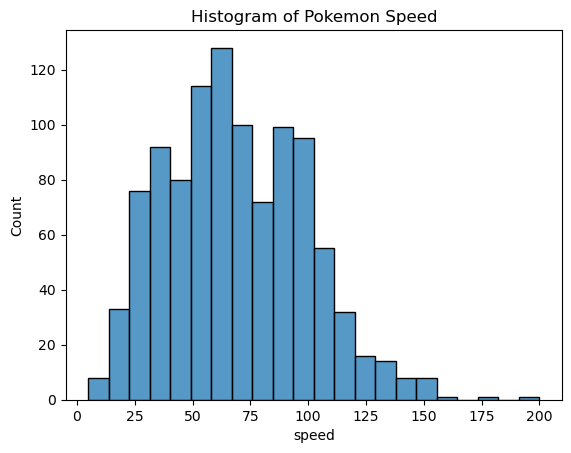

In [16]:
sns.histplot(pokemon_speed, x="speed")
plt.title("Histogram of Pokemon Speed")

## Getting abilities that affect speed
* 

## Covariance between Type and Speed
* Are GF designers relating a poke's type their speed intentionally?

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

In [33]:
x_train, x_test, y_train, y_test = train_test_split(poke_df[["speed", "attack", "hp", "sp_attack", "sp_defense", "defense"]], ((poke_df["type1"] == "Electric") | (poke_df["type2"] == "Electric")).apply(lambda x: 1 if x else 0), test_size=0.25, random_state=0)

In [34]:
model = LogisticRegression()

In [35]:
model.fit(x_train, y_train)

LogisticRegression()

In [42]:
y_pred = model.predict(x_test)
y_test

641     0
601     0
592     0
1028    0
317     0
       ..
278     0
561     1
320     0
236     0
513     0
Length: 259, dtype: int64

In [37]:
score = model.score(x_test, y_test)
score

0.9420849420849421

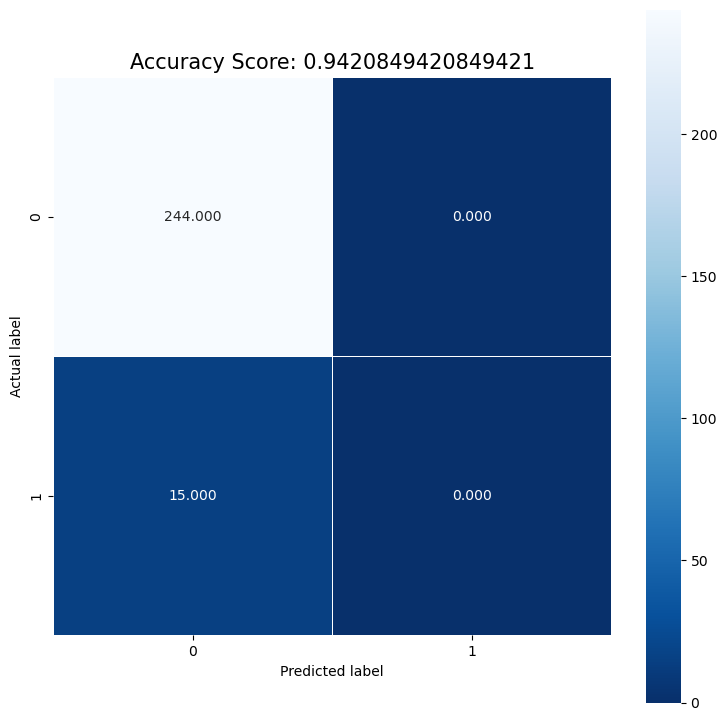

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics


cm = metrics.confusion_matrix(y_test, y_pred)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);